# Groundwater Flow Net Visualization with Python

This notebook demonstrates how to create groundwater flow nets using Python and matplotlib. Flow nets are graphical representations of groundwater flow patterns that show:

1. **Streamlines** (flow lines) - paths that water particles follow
2. **Equipotential lines** - lines of constant hydraulic head

You will develop flow nets for two scenarios:

1. Flow around a Source and Sink - Point sources and sinks in a flow field
2. Flow around a Cylinder - Obstacle in flow field

Additionally, you will implement the Kirkham analytical solution for groundwater flow to visualize head distributions under different boundary conditions, which you have seen in the physical hydrogeology class.

## Learning Objectives
- Learn to implement analytical solutions in Python
- Create publication-quality visualizations
- Apply flow net principles to practical problems


In [16]:
# Import required libraries
# NOTE: Nothing for you to do here
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

## 1. Flow around a Source and Sink

The source-sink pair is one of the most fundamental flow patterns in groundwater hydrology. It represents:
- **Source**: A point where water enters the aquifer (e.g., injection well)
- **Sink**: A point where water leaves the aquifer (e.g., pumping well)

For a source/sink of strength $Q$ at location $(x_0, y_0)$:

**Velocity potential**: $\phi = \frac{Q}{2\pi} \ln(r)$  
**Stream function**: $\psi = \frac{Q}{2\pi} \theta$  
**Velocity components**: $u = \frac{Q(x-x_0)}{2\pi r^2}$, $v = \frac{Q(y-y_0)}{2\pi r^2}$

Where $r = \sqrt{(x-x_0)^2 + (y-y_0)^2}$ and $\theta = \arctan\left(\frac{y-y_0}{x-x_0}\right)$

For this exercise, you will implement analytical solutions for source-sink flow and create flow net visualizations. For full credit:
 - Implement three functions to calculate:
    1. `velocity_source_sink`: Velocity components $(u, v)$ for a source or sink
    2. `stream_function_source_sink`: Stream function $\psi$
    3. `velocity_potential_source_sink`: Velocity potential $\phi$
 - Set up a computational domain with a source at $(-1, 0)$ and sink at $(1, 0)$, each with strength magnitude $|Q| = 5.0$
 - Compute the combined velocity field by superposition of source and sink contributions
 - Create a 2-panel figure showing:
    1. Flow net with streamlines (blue) and equipotential lines (red), with source and sink marked
    2. Velocity magnitude contour plot with source and sink locations
 - Make sure to label axes, add colorbars, and include titles for each panel.

In [17]:
def velocity_source_sink(Q, x0, y0, X, Y):
    """
    Calculate velocity components for a source/sink of strength Q located at (x0, y0).
    
    Parameters:
    Q: Source/sink strength (positive for source, negative for sink)
    x0, y0: x,y coordinate of the source/sink location
    X, Y: 2D array of x-coordinates where velocity is calculated
    
    Returns:
    u, v: Velocity components
    """
    dx = X - x0
    dy = Y - y0
    r_squared = dx**2 + dy**2
    # Avoid division by zero, don't change this line
    r_squared = np.maximum(r_squared, 1e-10)
    
    u = (Q * (X - x0)) / (2 * np.pi *r_squared)
    v = (Q * (Y - y0)) / (2 * np.pi *r_squared)
    
    return u, v

def stream_function_source_sink(Q, x0, y0, X, Y):
    """
    Stream function for a source/sink at (x0, y0):

    Parameters:
    Q: Source/sink strength (positive for source, negative for sink)
    x0, y0: Source/sink location
    X, Y: Coordinate grids

    Returns:
    psi: Stream function
    """
    dx = X - x0
    dy = Y - y0
    theta = np.arctan2(dy, dx) # Note, use np.arctan2 for correct angle calculation
    psi = (Q / (2 * np.pi)) * theta
    return psi

def velocity_potential_source_sink(Q, x0, y0, X, Y):
    """
    Velocity potential for a source/sink at (x0, y0):

    Parameters:
    Q: Source/sink strength (positive for source, negative for sink)
    x0, y0: Source/sink location
    X, Y: Coordinate grids
    
    Returns:
    phi: Velocity potential
    """
    dx = X - x0
    dy = Y - y0
    r = np.sqrt((dx)**2 + (dy)**2)
    # Avoid log(0), don't change this line
    r = np.maximum(r, 1e-10)
    phi = Q / (2 * np.pi) * np.log(r)
    return phi


In [18]:
# Define the computational domain
x_min, x_max = -3.0, 3.0
y_min, y_max = -2.0, 2.0
nx, ny = 200, 150

# Define source and sink parameters
Q_source = 5.0
Q_sink = -5.0
x_source, y_source = -1.0, 0.0
x_sink, y_sink = 1.0, 0.0

# Create coordinate grids
x = np.linspace(x_min, x_max, nx) 
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)

# Calculate velocity components
u_source, v_source = velocity_source_sink(Q_source, x_source, y_source, X, Y)
u_sink, v_sink = velocity_source_sink(Q_sink, x_sink, y_sink, X, Y)

# Combine source and sink velocities
u_total = u_source + u_sink
v_total = v_source + v_sink
velocity_magnitude = np.sqrt(u_total**2 + v_total**2)

# Create a mask to avoid singularities near source/sink
# NOTE: This will make the visualization cleaner
mask = ((X - x_source)**2 + (Y - y_source)**2 < 0.01) | ((X - x_sink)**2 + (Y - y_sink)**2 < 0.01)
velocity_magnitude = np.ma.masked_where(mask, velocity_magnitude)

# Calculate stream function and velocity potential
psi_source = stream_function_source_sink(Q_source, x_source, y_source, X, Y)
psi_sink = stream_function_source_sink(Q_sink, x_sink, y_sink, X, Y)
psi = psi_source + psi_sink

phi_source = velocity_potential_source_sink(Q_source, x_source, y_source, X, Y)
phi_sink = velocity_potential_source_sink(Q_sink, x_sink, y_sink, X, Y)
phi = phi_source + phi_sink

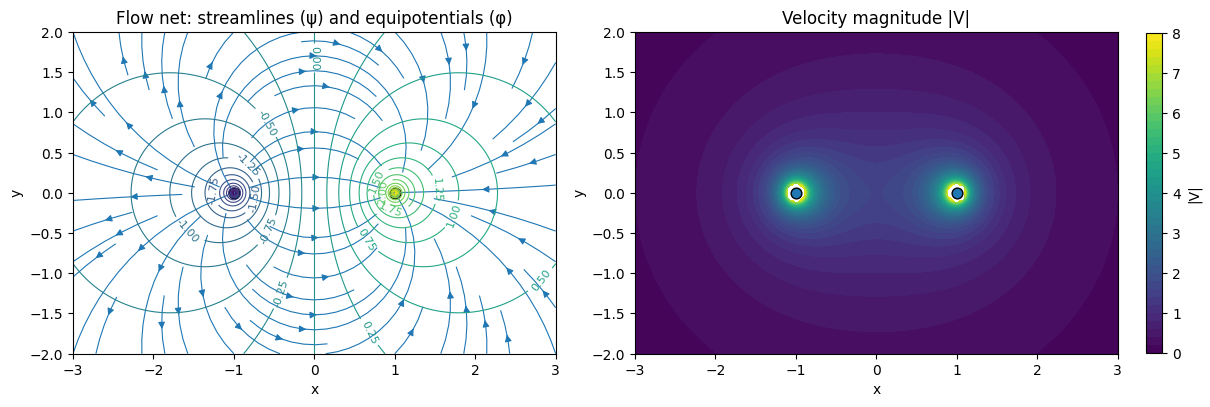

In [19]:
# Create comprehensive flow net visualization
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Stream function contours/flow net (left)
num_sl = 0.75 # Density of Flow lines (too dense and the plot gets messy and is slow)
num_eqpl = 30 # Number of equipotential lines (too many and the plot gets messy and is slow)
ax0.streamplot(x, y, u_total, v_total, density=num_sl, linewidth=0.8, arrowsize=1.0)  #Flow lines
cs = ax0.contour(X, Y, phi, levels=num_eqpl, linewidths=0.8) # Equipotential lines
ax0.clabel(cs, inline=True, fontsize=8, fmt="%.2f")  # Label equipotential lines using phi values
ax0.scatter([x_source, x_sink], [y_source, y_sink], s=60, marker="o", edgecolor="k")
ax0.set_title("Flow net: streamlines (ψ) and equipotentials (φ)")
ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_aspect("equal", adjustable="box")

# Velocity magnitude (right)
detail = 40  # Levels for smooth contour
cf = ax1.contourf(X, Y, velocity_magnitude, levels=detail)
ax1.scatter([x_source, x_sink], [y_source, y_sink], s=60, marker="o", edgecolor="k")
ax1.set_title("Velocity magnitude |V|")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal", adjustable="box")
fig.colorbar(cf, ax=ax1, shrink=0.65, label="|V|")
plt.show()

## 2. Flow around a Cylinder

This example demonstrates flow around an obstacle, which is common in groundwater systems with buried structures or geological features.

For uniform flow with velocity $U$ around a cylinder of radius $R$:

**Velocity potential**: $\phi(r, \theta) = U r \cos(\theta) + \frac{U R^2 \cos(\theta)}{r}$  
**Stream function**: $\psi(r, \theta) = U r \sin(\theta) - \frac{U R^2 \sin(\theta)}{r}$  
**Velocity components**: 
- Radial: $u_r(r, \theta) = U \cos(\theta)\left(1 - \frac{R^2}{r^2}\right)$
- Angular: $u_\theta(r, \theta) = -U \sin(\theta)\left(1 + \frac{R^2}{r^2}\right)$

For this exercise, you will implement potential flow around a circular cylinder and visualize the resulting flow patterns and pressure distribution. For full credit:
 - Implement three functions to calculate:
    1. `flow_around_cylinder`: Radial and tangential velocity components $(u_r, u_\theta)$ in polar coordinates
    2. `stream_function_cylinder`: Stream function $\psi$
    3. `velocity_potential_cylinder`: Velocity potential $\phi$
 - Set up a computational domain with a cylinder of radius $R = 1.0$ m centered at the origin, with uniform flow velocity $U = 2.0$ m/s
 - Convert velocity components from polar $(r, \theta)$ to Cartesian $(x, y)$ coordinates
 - Mask points inside the cylinder to properly represent the solid boundary
 - Create a 2-panel figure showing:
    1. Complete flow net with streamlines (blue) and equipotential lines (red), with the cylinder shown as a gray circle
    2. Pressure coefficient distribution $C_p = 1 - (V/U)^2$ using Bernoulli's equation
 - Make sure to label axes, add colorbars, and include titles for each panel.

In [20]:
def flow_around_cylinder(U, R, r, theta):
    """
    Calculate velocity components for flow around a cylinder
    Radial (ur) and tangential (utheta) velocities for uniform flow around a cylinder.

    Parameters:
    U: Free stream velocity
    R: Cylinder radius
    r: Radial distance from cylinder center
    theta: Angular coordinate
    
    Returns:
    ur, utheta: Radial and tangential velocity components
    """
    # Avoid division by zero and points inside cylinder
    r_safe = np.maximum(r, R + 1e-6)
    
    # Radial velocity component
    ur = U * np.cos(theta) * (1.0 - (R**2) / (r_safe**2))

    # Tangential velocity component
    utheta = -U * np.sin(theta) * (1.0 + (R**2) / (r_safe**2))

    return ur, utheta

def stream_function_cylinder(U, R, r, theta):
    """
    Calculate stream function for flow around a cylinder
    Stream function ψ = U r sinθ - U R^2 sinθ / r

    Parameters:
    U: Free stream velocity
    R: Cylinder radius
    r: Radial distance from cylinder center
    theta: Angular coordinate

    Returns:
    psi: Stream function
    """
    # Avoid division by zero and points inside cylinder
    r_safe = np.maximum(r, R + 1e-6)
    psi = U * r_safe * np.sin(theta) - U * (R**2) * np.sin(theta) / r_safe
    return psi

def velocity_potential_cylinder(U, R, r, theta):
    """
    Calculate velocity potential for flow around a cylinder
    Velocity potential φ = U r cosθ + U R^2 cosθ / r

    Parameters:
    U: Free stream velocity
    R: Cylinder radius
    r: Radial distance from cylinder center
    theta: Angular coordinate

    Returns:
    phi: Velocity potential
    """
    # Avoid division by zero and points inside cylinder
    r_safe = np.maximum(r, R + 1e-6)
    phi = U * r_safe * np.cos(theta) + U * (R**2) * np.cos(theta) / r_safe
    return phi


In [21]:
# Flow around a cylinder
# Define parameters
U = 2.0  # Free stream velocity
R = 1.0  # Cylinder radius
x_center, y_center = 0.0, 0.0  # Cylinder center

# Create coordinate grids
# Field of view around the cylinder
scale = 3.0 # use a value between 3.0 & 5.0: See how it changes your plots *Inverse scale

# Domain resolution (number of points)
resolution = 1000  # use a value between 100 & 500: See how it changes your plots smoothness and speed

x_cyl = np.linspace(-R*scale, R*scale, resolution)
y_cyl = np.linspace(-R*scale, R*scale, resolution)
X_cyl, Y_cyl = np.meshgrid(x_cyl, y_cyl)

# Convert to polar coordinates relative to cylinder center
r = np.sqrt((X_cyl - x_center)**2 + (Y_cyl - y_center)**2)
theta = np.arctan2(Y_cyl - y_center, X_cyl - x_center)

# Calculate velocity components
ur, utheta = flow_around_cylinder(U, R, r, theta)

# Convert to Cartesian coordinates
u_cyl = ur * np.cos(theta) - utheta * np.sin(theta)
v_cyl = ur * np.sin(theta) + utheta * np.cos(theta)

# Calculate stream function and velocity potential
psi_cyl = stream_function_cylinder(U, R, r, theta)
phi_cyl = velocity_potential_cylinder(U, R, r, theta)

# Mask points inside the cylinder
# Masking makes the visualization cleaner
mask_inside = r < R
u_cyl = np.ma.masked_where(mask_inside, u_cyl)
v_cyl = np.ma.masked_where(mask_inside, v_cyl)
psi_cyl = np.ma.masked_where(mask_inside, psi_cyl)
phi_cyl = np.ma.masked_where(mask_inside, phi_cyl)

# Pressure distribution (using Bernoulli's equation)

velocity_magnitude_cyl = np.sqrt(u_cyl**2 + v_cyl**2)
# Pressure coefficient Cp = 1 - (V/U)²
Cp = 1.0 - (velocity_magnitude_cyl / U)**2
# Makes the visualization cleaner
Cp = np.ma.masked_where(mask_inside, Cp)

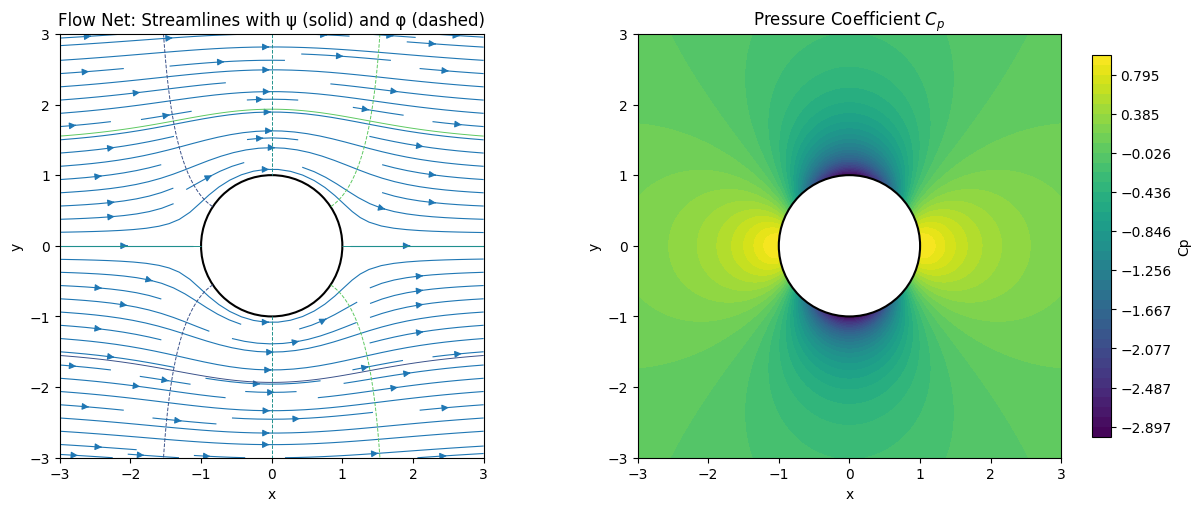

In [22]:
# Visualize flow around cylinder
# Create figure and 2 axes using plt.subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Combined flow net
# Use the ax.streamplot, ax.contour to plot
# Prepare velocity arrays for streamplot (NaN where masked so lines don’t cross the cylinder)
u_plot = np.where(np.ma.getmaskarray(u_cyl), np.nan, np.asarray(u_cyl, dtype=float))
v_plot = np.where(np.ma.getmaskarray(v_cyl), np.nan, np.asarray(v_cyl, dtype=float))

# Streamlines
ax1.streamplot(X_cyl, Y_cyl, u_plot, v_plot, density=1.1, linewidth=0.8, arrowsize=1.0)

# ψ and φ contours
n_levels = 5  # Number of contour levels: Play with this to see how it changes your plots
psi_levels = np.linspace(np.ma.min(psi_cyl), np.ma.max(psi_cyl), n_levels)
phi_levels = np.linspace(np.ma.min(phi_cyl), np.ma.max(phi_cyl), n_levels)

c_psi = ax1.contour(X_cyl, Y_cyl, psi_cyl, levels=psi_levels, linewidths=0.7)
c_phi = ax1.contour(X_cyl, Y_cyl, phi_cyl, levels=phi_levels, linewidths=0.7, linestyles="--")

# ax1.clabel(c_psi, inline=True, fontsize=10, fmt="ψ=%.2f")  # Label streamlines using psi values 
# ax1.clabel(c_phi, inline=True, fontsize=10, fmt="φ=%.2f")  # Label equipotential lines using phi values

# Cylinder boundary
ax1.add_patch(plt.Circle((x_center, y_center), R, fill=False, linewidth=1.5))

ax1.set_title("Flow Net: Streamlines with ψ (solid) and φ (dashed)")
ax1.set_xlabel("x"); ax1.set_ylabel("y")
ax1.set_aspect("equal", adjustable="box")  # Set equal aspect ratio
ax1.set_xlim(X_cyl.min(), X_cyl.max()); ax1.set_ylim(Y_cyl.min(), Y_cyl.max())

# Pressure coefficient distribution
# Use the ax.contourf to plot, and add colorbar
cp_levels = np.linspace(-3.0, 1.0, 40)
cf = ax2.contourf(X_cyl, Y_cyl, Cp, levels=cp_levels)
fig.colorbar(cf, ax=ax2, shrink=0.9, label="Cp")

# Cylinder boundary
ax2.add_patch(plt.Circle((x_center, y_center), R, fill=False, linewidth=1.5))

ax2.set_title("Pressure Coefficient $C_p$")
ax2.set_xlabel("x"); ax2.set_ylabel("y")
ax2.set_aspect("equal", adjustable="box")  #Set equal aspect ratio
ax2.set_xlim(X_cyl.min(), X_cyl.max()); ax2.set_ylim(Y_cyl.min(), Y_cyl.max())

plt.show()


## 3. Kirkham's Analytical Solution

The Kirkham solution represents steady-state flow in a rectangular aquifer draining to an open ditch.

The solution can be written as:

$$
C = \frac{8D}{\pi^2}
$$

$$
H_{i,j} = \sum_{n=1,3,5,\ldots}^{N_n} \frac{C}{n^2} \cdot \cos\left(\frac{n\pi D_c}{2D}\right) \cdot \cos\left(\frac{n\pi z}{2D}\right) \cdot \frac{\cosh\left(\frac{n\pi(B-x)}{2D}\right)}{\cosh\left(\frac{n\pi B}{2D}\right)}
$$

The summation can be expanded step-by-step as:
$$
\begin{align}
C &= \frac{8D}{\pi^2} \\
C_1 &= \frac{C}{n^2} \\
C_2 &= C_1 \cdot \cos\left(\frac{n\pi D_c}{2D}\right) \\
C_3 &= C_2 \cdot \cos\left(\frac{n\pi z_j}{2D}\right) \\
C_4 &= C_3 \cdot \cosh\left(\frac{n\pi(B-x)}{2D}\right) \\
C_5 &= \frac{C_4}{\cosh\left(\frac{n\pi B}{2D}\right)} \\
H &= H + C_5
\end{align}
$$

Finally, the computation of the head field:
$$
\mathbf{H} = D - \mathbf{H}
$$

For this exercise, you will implement Kirkham's solution in Python and visualize the results using matplotlib. For full credit:
 - Implement the Kirkham solution function `kirkham_head`
 - Use your implementation to compute head distributions for two scenarios with different values of `D_c` (Use `D_c = 2.0 m` and `D_c = 6.0 m`)
 - Create a 3-panel figure showing:
    1. Head distribution for Scenario 1
    2. Head distribution for Scenario 2
    3. Difference in head between the two scenarios
 - Make sure to label axes, add colorbars, and include titles for each panel.

In [23]:
def kirkham_head(D=1.0, B=1.0, D_c=0.2, Nxz=101, Nn=201):
    """
    Compute the steady-state hydraulic head H(x,z) in a rectangular aquifer
    using the analytical solution of Kirkham (1953).

    Parameters
    ----------
    D:   Aquifer thickness (m)
    B:   Aquifer width (m)
    D_c: Depth to the center of the drain (m)
    Nxz: Number of discretization points in x and z directions
    Nn:  Number of terms in the series expansion (odd integers only)

    Returns
    -------
    H: Head field with H[i, j] corresponding to (x[i], z[j]) ndarray of shape (Nxz, Nxz)
    x: 1D x-coordinates (ndarray)
    z: 1D z-coordinates (ndarray)
    """
    # Discretization grids
    x = np.linspace(0.0, B, Nxz)
    z = np.linspace(0.0, D, Nxz)

    # Set up meshgrid for calculations
    # NOTE: Don't change this line
    X, Z = np.meshgrid(x, z, indexing="ij")

    # Odd series terms
    n_values = np.arange(1, Nn + 1, 2)
    C = (8.0 * D) / (np.pi**2)

    # Initialize head field with zeros, of size (Nxz, Nxz)
    H = np.zeros_like(X, dtype=float)

    # Compute series sum term by term
    for n in n_values:
        C_1 = C / (n**2)
        C_2 = C_1 * np.cos((n * np.pi * D_c) / (2.0 * D))
        C_3 = C_2 * np.cos((n * np.pi * Z)   / (2.0 * D))
        C_4 = C_3 * np.cosh((n * np.pi * (B - X)) / (2.0 * D))
        C_5 = C_4 / np.cosh((n * np.pi * B) / (2.0 * D))
        H += C_5

    H = D - H
    return H, x, z

In [24]:
# Kirkham solution - Define parameters
D = 10.0      # Aquifer depth (m)
B = 50.0      # Aquifer breadth (m)
Nxz = 151     # Grid resolution
Nn = 50       # Number of odd series terms

# Calculate head distributions for two different D_c values
H1, x_kirk, z_kirk = kirkham_head(D=D, B=B, D_c=2.0, Nxz=Nxz, Nn=Nn)
H2, _, _           = kirkham_head(D=D, B=B, D_c=6.0, Nxz=Nxz, Nn=Nn)  # NOTE: Underscore to ignore unused outputs

# Calculate the difference between the two scenarios
H_diff = H2 - H1

# Create meshgrids for plotting
X_kirk, Z_kirk = np.meshgrid(x_kirk, z_kirk, indexing='ij')


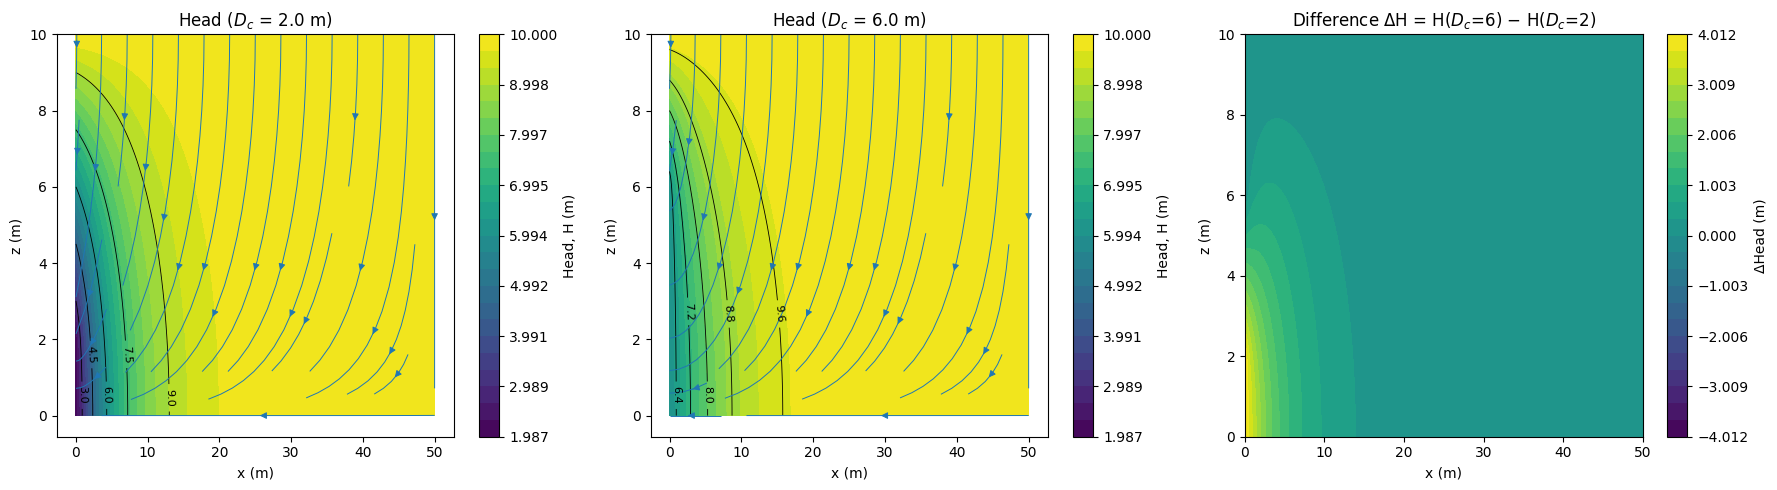

In [25]:
# Create 3-panel plot with head distributions and streamlines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Common contour levels for H so panels are comparable
n_levels = 25  # Number of contour levels: Play with this to see how it changes your plots
hmin = min(np.min(H1), np.min(H2))
hmax = max(np.max(H1), np.max(H2))
levels_H = np.linspace(hmin, hmax, n_levels)

# Streamline fields from head gradients (flow ∝ -∇H)
dH1_dx, dH1_dz = np.gradient(H1, x_kirk, z_kirk, edge_order=2)
u1, w1 = -dH1_dx, -dH1_dz

dH2_dx, dH2_dz = np.gradient(H2, x_kirk, z_kirk, edge_order=2)
u2, w2 = -dH2_dx, -dH2_dz

# Panel 1: Head distribution for first D_c value
# Use ax.contourf and ax.contour to draw filled contours and contour lines
num_sl = 0.5  # Density of streamlines
num_eqpl = 5  # Number of equipotential lines
cf1 = ax1.contourf(X_kirk, Z_kirk, H1, levels=levels_H)
c1  = ax1.contour (X_kirk, Z_kirk, H1, levels=num_eqpl, colors="k", linewidths=0.6)
ax1.clabel(c1, inline=True, fontsize=8)
# streamlines — IMPORTANT: streamplot wants (y,x) order → transpose u,v since H is (x,z)
ax1.streamplot(x_kirk, z_kirk, u1.T, w1.T, density=num_sl, linewidth=0.7, arrowsize=1.0)
fig.colorbar(cf1, ax=ax1, shrink=1.0, label="Head, H (m)")
ax1.set_title("Head ($D_c$ = 2.0 m)")
ax1.set_xlabel("x (m)"); ax1.set_ylabel("z (m)")
# ax1.set_aspect("auto")

# Panel 2: Head distribution for second D_c value
# Use ax.contourf and ax.contour to draw filled contours and contour lines
cf2 = ax2.contourf(X_kirk, Z_kirk, H2, levels=levels_H)
c2  = ax2.contour (X_kirk, Z_kirk, H2, levels=num_eqpl, colors="k", linewidths=0.6)
ax2.clabel(c2, inline=True, fontsize=8)
# streamlines — same transpose for u,v with .T
ax2.streamplot(x_kirk, z_kirk, u2.T, w2.T, density=num_sl, linewidth=0.7, arrowsize=1.0)
fig.colorbar(cf2, ax=ax2, shrink=1.0, label="Head, H (m)")
ax2.set_title("Head ($D_c$ = 6.0 m)")
ax2.set_xlabel("x (m)"); ax2.set_ylabel("z (m)")
# ax2.set_aspect("auto")

# Panel 3: Difference in head between scenarios
# Use ax.contourf to draw filled contours
vmax = np.nanmax(np.abs(H_diff))
levels_d = np.linspace(-vmax, vmax, n_levels)  # Symmetric levels around zero
cf3 = ax3.contourf(X_kirk, Z_kirk, H_diff, levels=levels_d)
fig.colorbar(cf3, ax=ax3, shrink=1.0, label="ΔHead (m)")
ax3.set_title("Difference ΔH = H($D_c$=6) − H($D_c$=2)")
ax3.set_xlabel("x (m)"); ax3.set_ylabel("z (m)")
# ax3.set_aspect("auto")

plt.tight_layout()
plt.show()
